## Input for read recruitment:
```
clc_mapper -o 1.108.O.s1c1.rearrange.cas -p fb ss 100 300 -q ../1.108.O.*.fastq -d 1.108.O.s1c1.rearrange.fasta -a local -r ignore 
clc_extract_consensus -z none -a 1.108.O.s1c1.rearrange.cas -o 1.108.O.s1c1.rearrange.rerecruit.fasta
clc_cas_to_sam -a 1.108.O.s1c1.rearrange.cas -o 1.108.O.rearrange.bam
samtools sort 1.108.O.rearrange.bam 1.108.O.rearrange.sorted
samtools index 1.108.O.rearrange.sorted.bam
bedtools genomecov -ibam 1.108.O.rearrange.sorted.bam -d > 1.108.O.rearrange.genomecoverage.txt
```

### load onto server:

In [ ]:
# %load read_coverage.py
#!usr/bin/python
import glob
import subprocess
import os
import sys
import argparse

def call_cmd(command, std_out):
    if std_out:
        output = open(std_out, "w")
        subprocess.call(command.split(" "), stdout=output)
        output.close()
    else:
        subprocess.call(command.split(" "))

remove_temps = lambda t: os.remove(t) 

def recruit_reads(read_fastq, reference_fasta, out_file):
    cmd1 = "clc_mapper -o tmp.cas -p fb ss 100 300 -q %s -d %s -a local -r ignore" % (read_fastq, reference_fasta)
    cmd2 = "clc_cas_to_sam -a tmp.cas -o tmp.bam" 
    cmd3 = "samtools sort tmp.bam tmp_sorted" 
    cmd4 = "samtools index tmp_sorted.bam" 
    cmd5 = "bedtools genomecov -ibam tmp_sorted.bam -d" 
    
    cmds = [cmd1, cmd2, cmd3, cmd4]
    
    for c in cmds:
        print(c)
        call_cmd(c, std_out=False)
        
    print(cmd5)
    call_cmd(cmd5, std_out=out_file)
    
    for t in glob.glob("tmp*"):
        remove_temps(t) 
    
'''
if __name__ == "__main__":
    def _file_exists(parser, arg):
        if not os.path.exists(arg):
                    parser.error("The file %s does not exist" % arg)
        if not os.path.isfile(arg):
                    parser.error("Expected file, not folder (%s)" % arg)
        return arg
        
    p = argparse.ArgumentParser(prog="read_coverage.py", description="outputs read coverage values for input assembly \
    using input reads file", formatter_class=argparse.ArgumentDefaultsHelpFormatter)
    p.add_argument('read_file', type=lambda x: _file_exists(p, x), help="fastq file path")
    p.add_argument('reference_fasta', type=lambda x: _file_exists(p, x), help="fasta file path")
    p.add_argument('output_file', help="name of output text file")
    args=p.parse_args()
    recruit_reads(args.read_file, args.reference_fasta, args.output_file)
'''
    

### Run in ipython in folder /nobackup1/jbrown/nahant_phage_pacbio/

In [ ]:
# %load ./scripts/compare_recruitment.py
#!usr/bin/python

import os
import glob
import shutil

from read_coverage import *

phages=open("K2.151228_PacBio_Nahant_Phages.txt").readlines()
phages=[i.replace("\r\n","") for i in phages]

for p in phages:

    cir_fasta = "/nobackup1/jbrown/nahant_phage_pacbio/contigs/hgap2_circularized/%shgap2.cir.fasta" % p
    
    if os.path.exists(cir_fasta) and os.path.getsize(cir_fasta)==0:
        print "%s failed circularization" % p
        hgap2_contig = "/nobackup1/jbrown/nahant_phage_pacbio/contigs/%s/%s_kkhgap2.fasta" % (p, p)
    elif os.path.exists(cir_fasta) and os.path.getsize(cir_fasta)>0:
        print "%s circularized" % p
        hgap2_contig = cir_fasta
    elif os.path.exists("/nobackup1/jbrown/nahant_phage_pacbio/contigs/%s/%s _kkhgap2.fasta" % (p, p)):
        hgap2_contig = "/nobackup1/jbrown/nahant_phage_pacbio/contigs/%s/%s _kkhgap2.fasta" % (p, p)
        print "%s not circularized" % p
    else:
        print "contig for %s not present in kkhgap2 assembly" % p
        hgap2_contig = None

    if hgap2_contig != None:
        fastq = glob.glob("/nobackup1/jbrown/nahant_phage_reads/%s*.fastq" % p)[0]
        output = "/nobackup1/jbrown/nahant_phage_pacbio/illuminacov/%s_kkhgap_illumina_readrecruitment.txt" % p        
        recruit_reads(fastq, hgap2_contig, output)
        output1 = "/nobackup1/jbrown/nahant_phage_pacbio/illuminacov/%s_illumina_final_contig_readrecruitment.txt" % p
        contig = "/nobackup1/jbrown/annotation/genomes/%sfinal.fasta" % p
        recruit_reads(fastq, contig, output1)
        shutil.copyfile(hgap2_contig, "/nobackup1/jbrown/nahant_phage_pacbio/contigs/%s/%s_kkhgap2_best.fasta" % (p, p))
        

### Transfer resulting read coverage files back to mac:
```
scp /nobackup1/jbrown/nahant_phage_pacbio/illuminacov/* jmb@alarmism.einstein.yu.edu:~/Desktop/ViralFate/PacBio/data/kkhgap2_illuminacov/
```

In [12]:
%load_ext rpy2.ipython
%R library(dplyr); library(ggplot2); library(magrittr)

//anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: 
Attaching package: ‘dplyr’


  res = super(Function, self).__call__(*new_args, **new_kwargs)
//anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: The following objects are masked from ‘package:stats’:

    filter, lag


  res = super(Function, self).__call__(*new_args, **new_kwargs)
//anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


  res = super(Function, self).__call__(*new_args, **new_kwargs)
//anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Use suppressPackageStartupMessages to eliminate package startup messages.

  res = super(Function, self).__call__(*new_args, **new_kwargs)


array(['magrittr', 'ggplot2', 'dplyr', 'tools', 'stats', 'graphics',
       'grDevices', 'utils', 'datasets', 'methods', 'base'], 
      dtype='|S9')

In [50]:
coverage_files = glob.glob("./data/kkhgap2_illuminacov/*")
phagelist = list(set([i.split("/")[-1].split("_")[0] for i in coverage_files]))
phagelist

['2.096.O.',
 '1.211.B.',
 '1.176.O.',
 '1.161.O.',
 '1.232.O.',
 '1.054.O.',
 '1.190.O.',
 '1.177.O.',
 '1.193.O.',
 '1.121.O.',
 '1.187.O.',
 '1.084.O.',
 '1.090.B.',
 '1.189.O.',
 '1.151.O.',
 '1.276.O.',
 '1.205.O.',
 '2.095.B.',
 '1.110.O.',
 '1.262.O.',
 '1.261.O.',
 '1.123.O.',
 '1.042.O.',
 '1.082.O.',
 '1.074.O.',
 '1.239.O.',
 '1.148.O.',
 '1.275.O.',
 '1.215.A.',
 '1.185.O.',
 '1.257.O.',
 '1.135.O.',
 '1.216.O.',
 '1.259.O.',
 '1.007.O.',
 '1.029.O.',
 '1.144.O.',
 '2.275.O.',
 '1.231.O.',
 '1.210.O.',
 '1.170.O.',
 '2.130.O.',
 '1.063.O.',
 '1.293.O.',
 '1.283.C.',
 '1.255.O.',
 '2.117.O.',
 '1.131.O.',
 '1.228.O.',
 '1.291.O.',
 '1.122.B.',
 '1.233.B.',
 '1.154.O.',
 '1.182.O.']

In [51]:
ls ./data/kkhgap2_illuminacov/*

./data/kkhgap2_illuminacov/1.007.O._illumina_final_contig_readrecruitment.txt
./data/kkhgap2_illuminacov/1.007.O._kkhgap_illumina_readrecruitment.txt
./data/kkhgap2_illuminacov/1.029.O._illumina_final_contig_readrecruitment.txt
./data/kkhgap2_illuminacov/1.029.O._kkhgap_illumina_readrecruitment.txt
./data/kkhgap2_illuminacov/1.042.O._illumina_final_contig_readrecruitment.txt
./data/kkhgap2_illuminacov/1.042.O._kkhgap_illumina_readrecruitment.txt
./data/kkhgap2_illuminacov/1.054.O._illumina_final_contig_readrecruitment.txt
./data/kkhgap2_illuminacov/1.054.O._kkhgap_illumina_readrecruitment.txt
./data/kkhgap2_illuminacov/1.063.O._illumina_final_contig_readrecruitment.txt
./data/kkhgap2_illuminacov/1.063.O._kkhgap_illumina_readrecruitment.txt
./data/kkhgap2_illuminacov/1.074.O._illumina_final_contig_readrecruitment.txt
./data/kkhgap2_illuminacov/1.074.O._kkhgap_illumina_readrecruitment.txt
./data/kkhgap2_illuminacov/1.082.O._illumina_final_contig_readrecruitment.txt
./data/kkhgap2_illumin

In [52]:
%%R
all_info<-read.table("../genome_data/data/all_info.txt", sep="\t", header=T)
head(all_info)

     phage num_hosts min_host_similarity kk_grp        family          order
1 1.003.O.         2            76.77842      1  Podoviridae   Caudovirales 
2 1.004.O.         5            99.62443     14   Myoviridae   Caudovirales 
3 1.005.O.         1           100.00000      7  Podoviridae   Caudovirales 
4 1.007.O.         1           100.00000      1   Myoviridae   Caudovirales 
5 1.008.O.        36            73.57059     15    Tectivirus   Tectiviridae
6 1.009.O.         1           100.00000      7  Podoviridae   Caudovirales 
  nucleotide_level_divs illumina_genome_len bray_clusters_eps0.9
1                     1               41891                    1
2                     2               42511                    2
3                     3               50301                    3
4                     4               49244                    4
5                     5               10579                    5
6                     6               44443                    0
  eucl

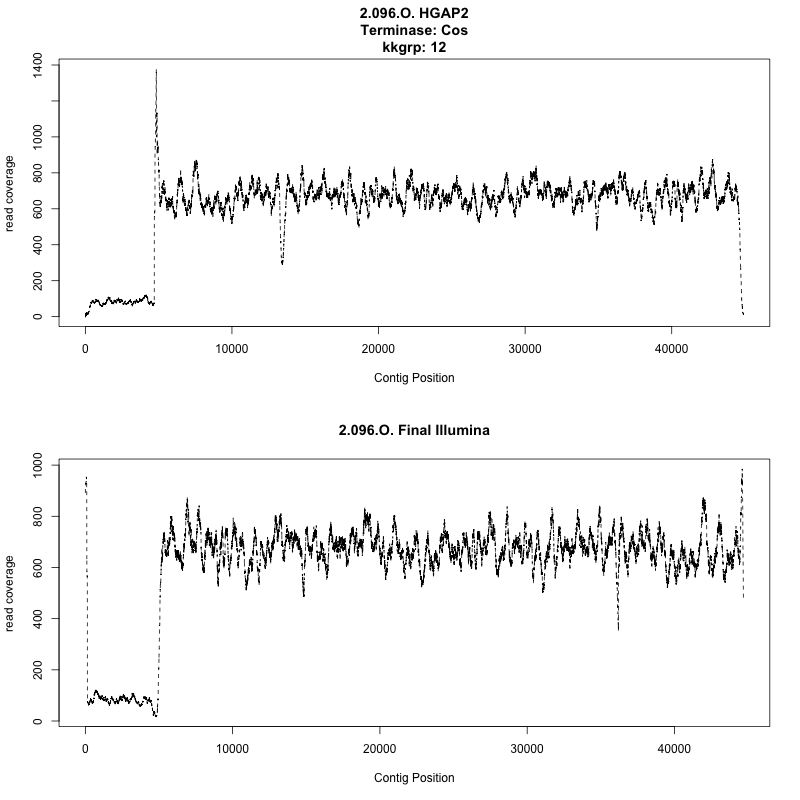

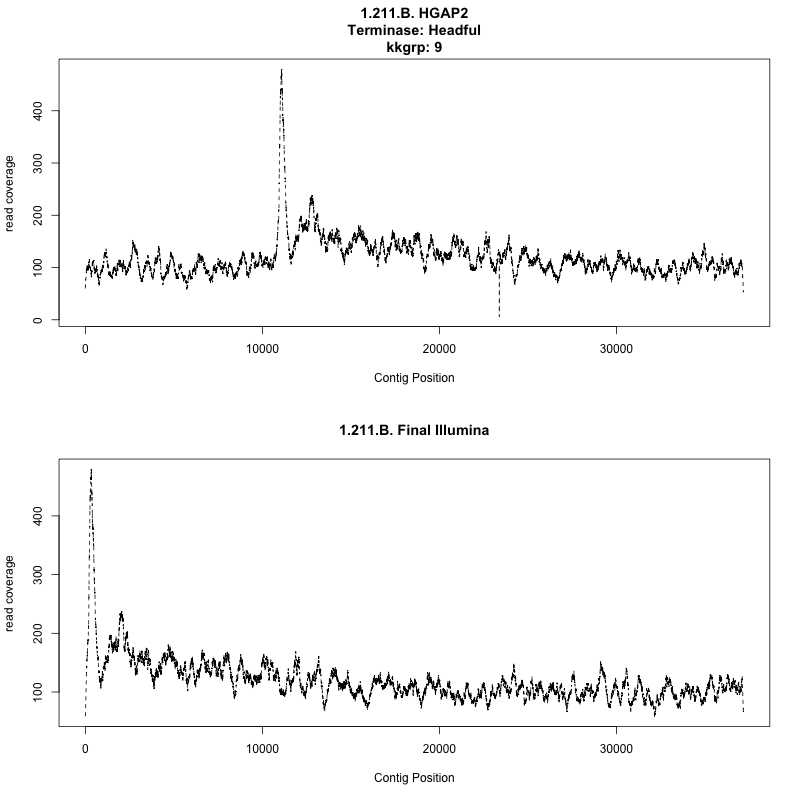

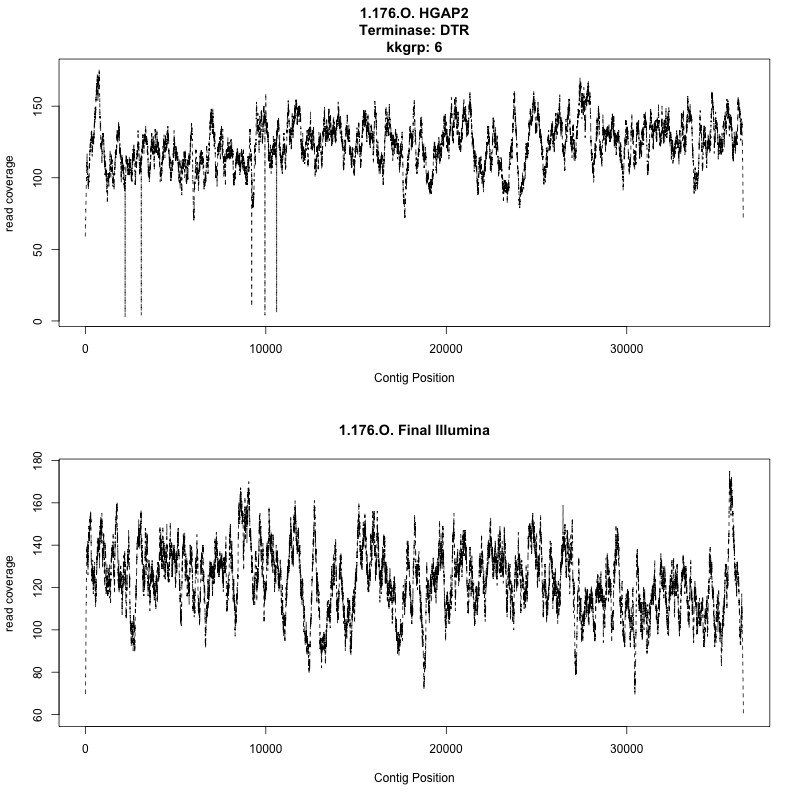

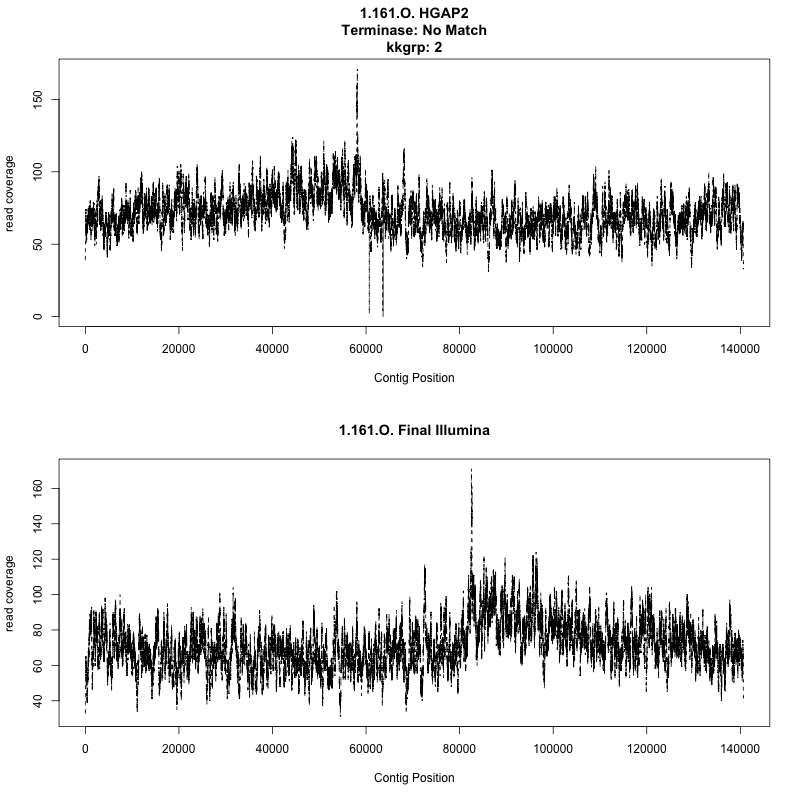

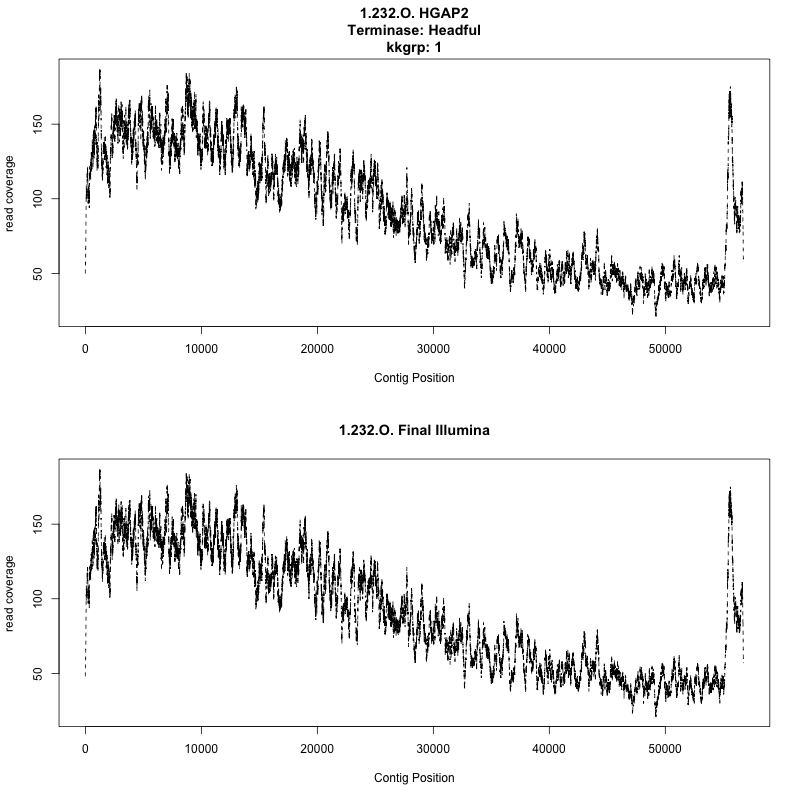

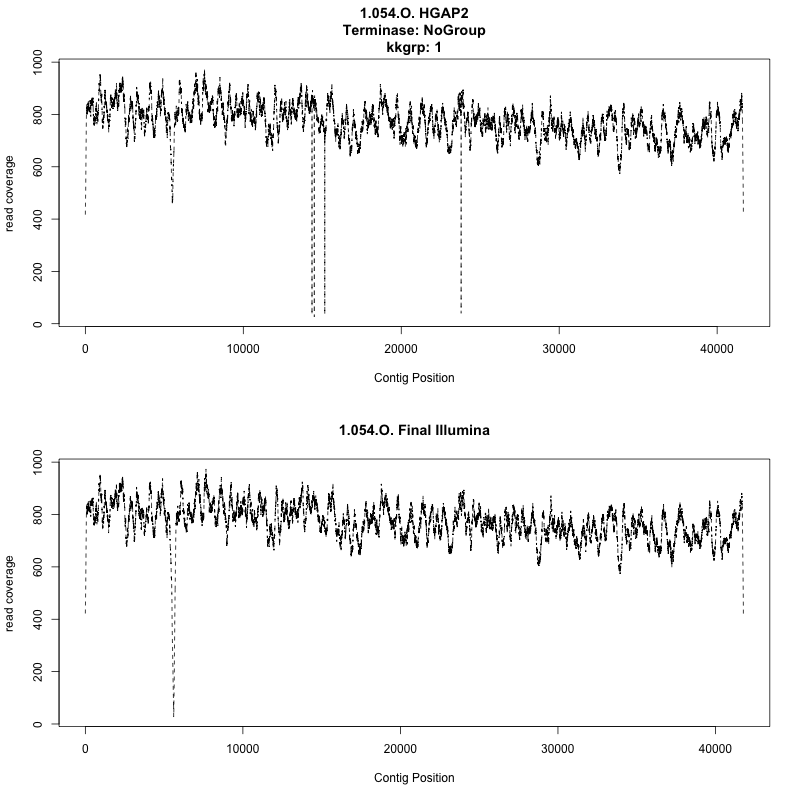

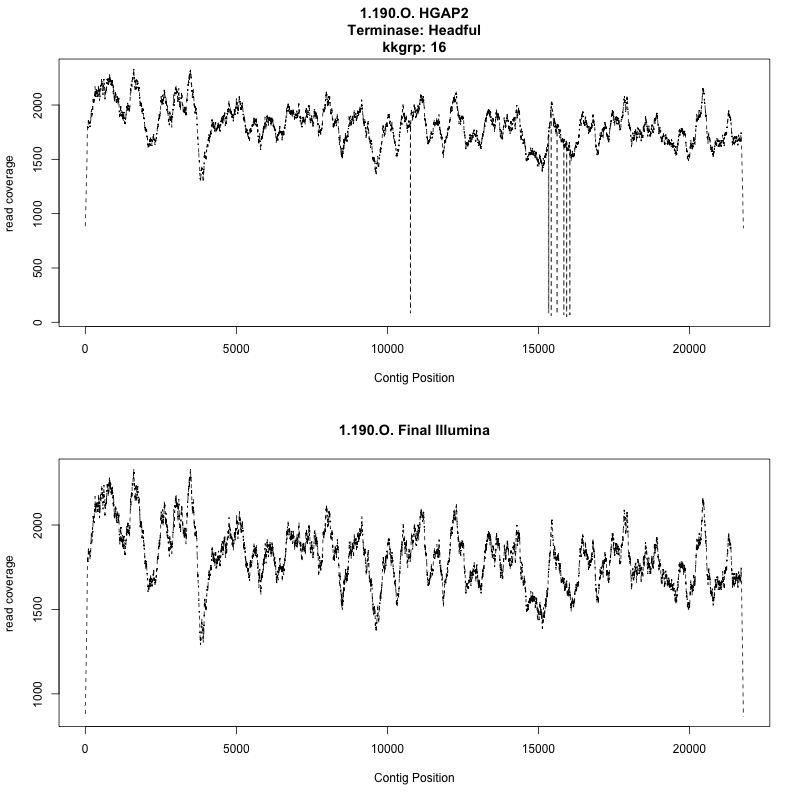

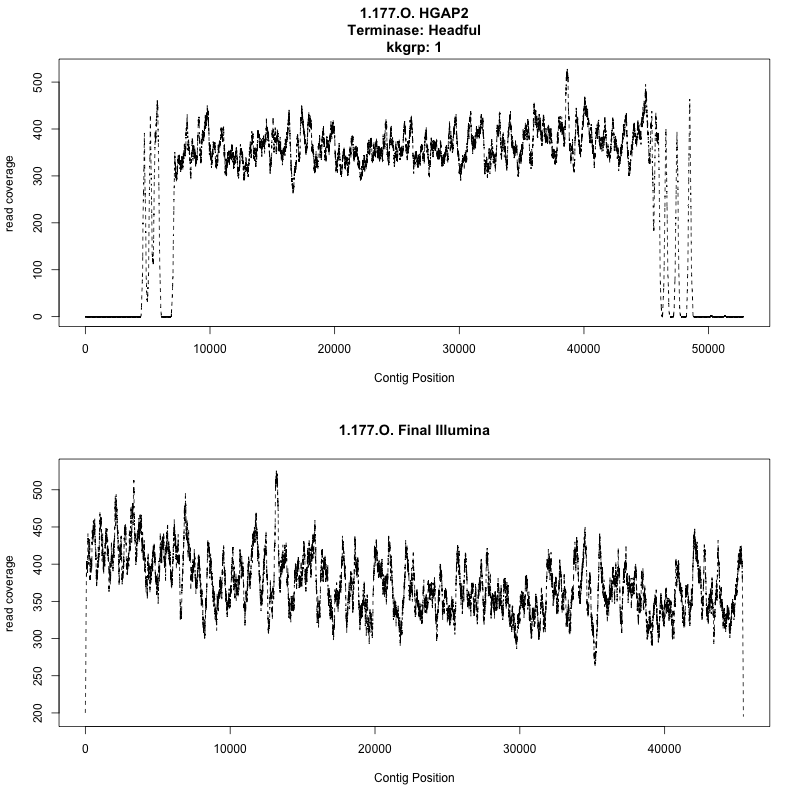

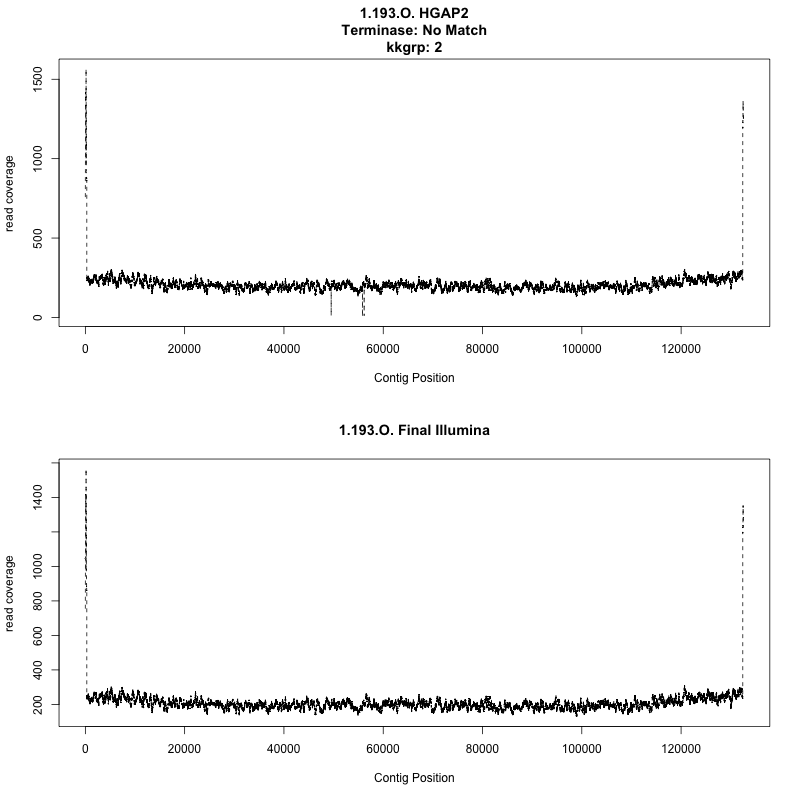

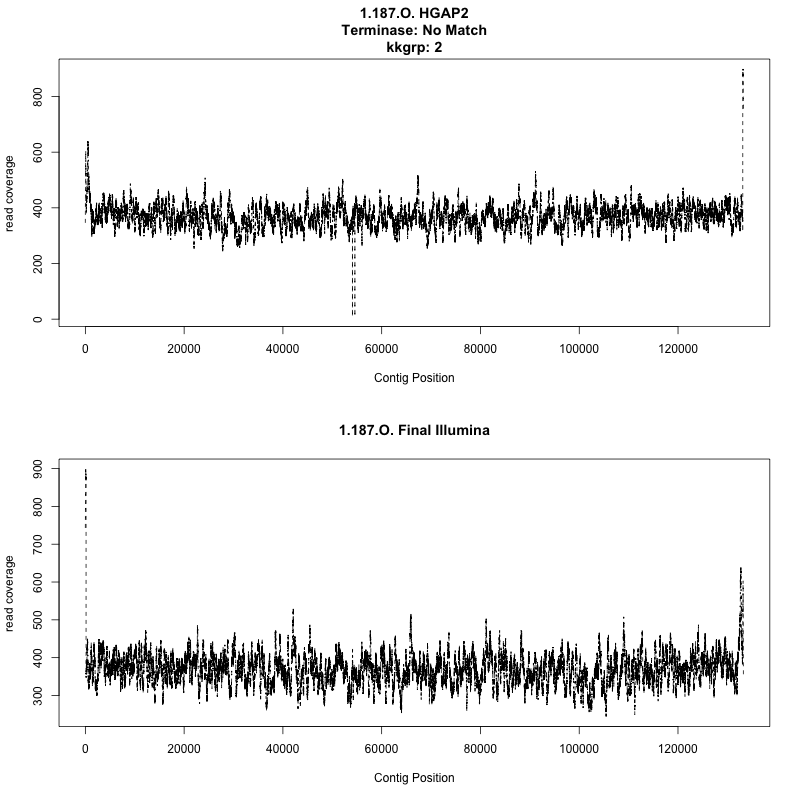

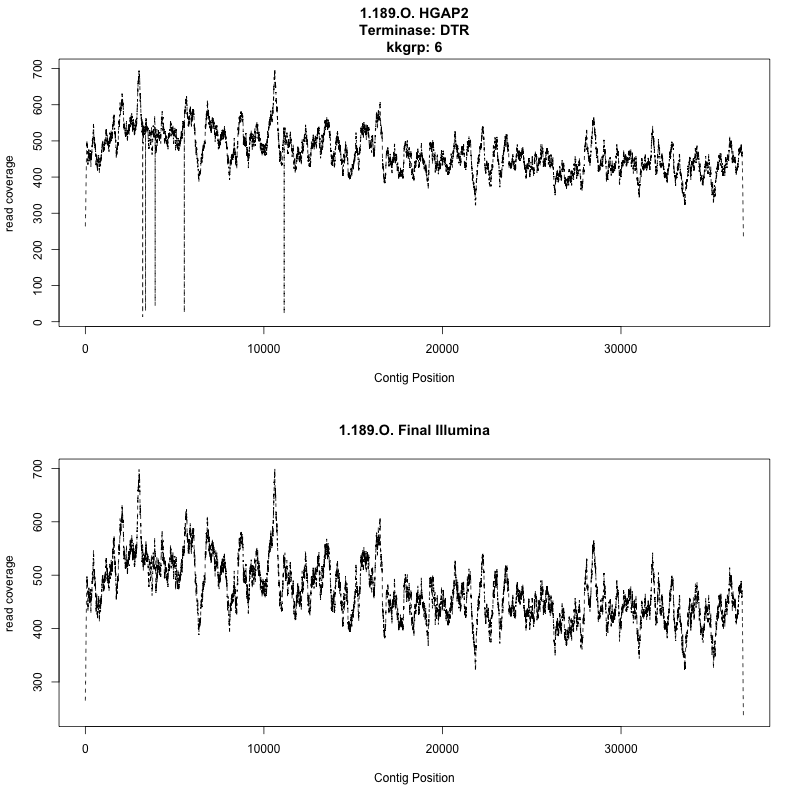

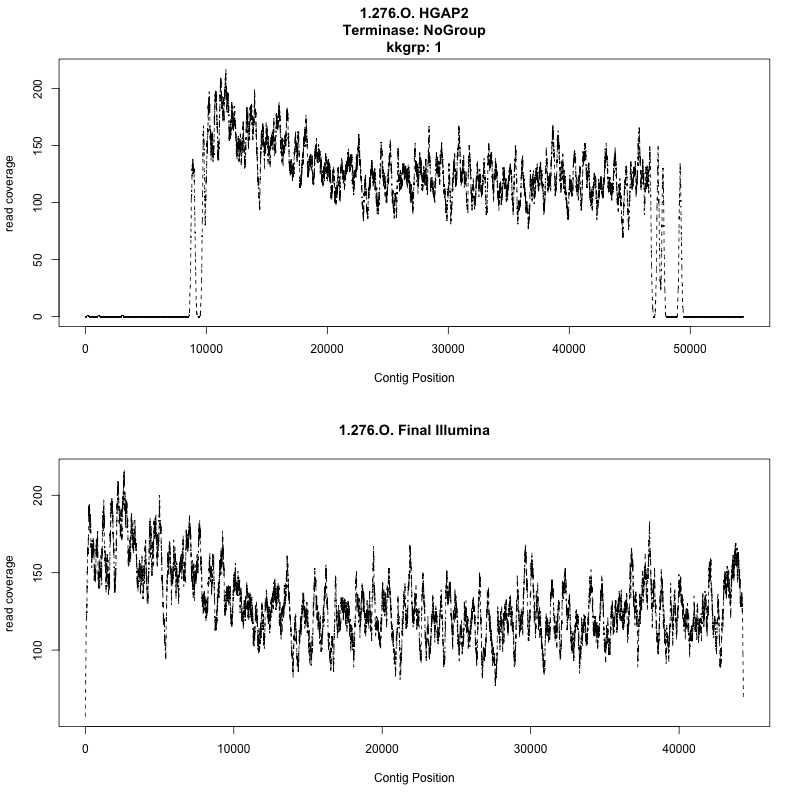

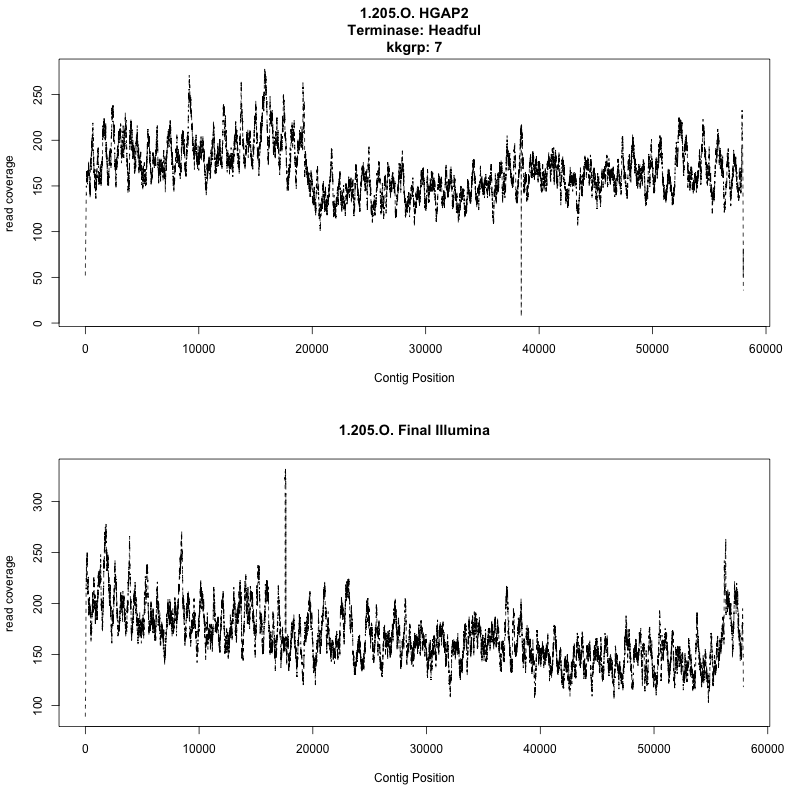

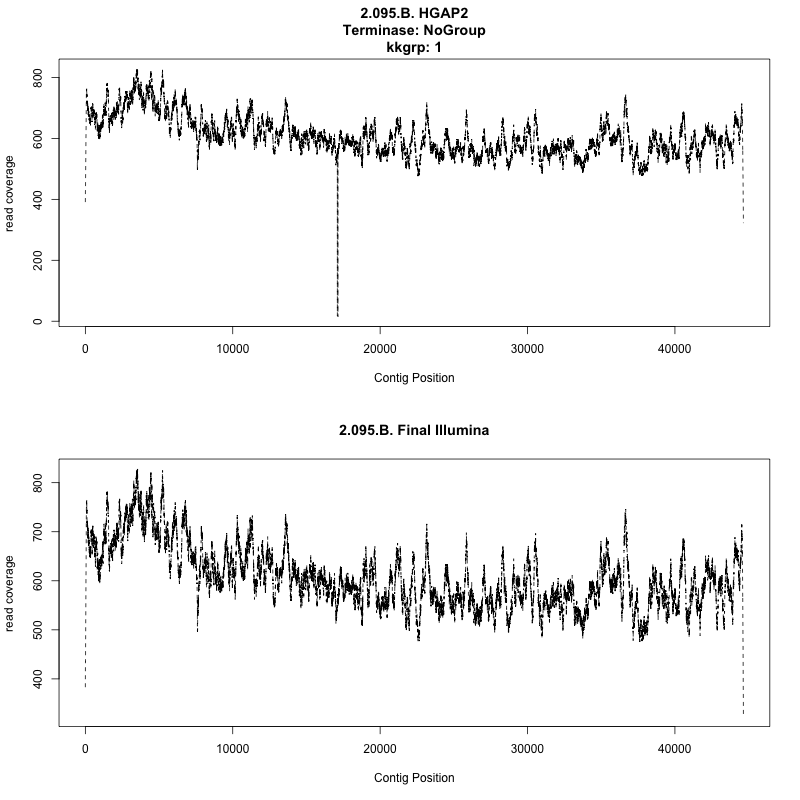

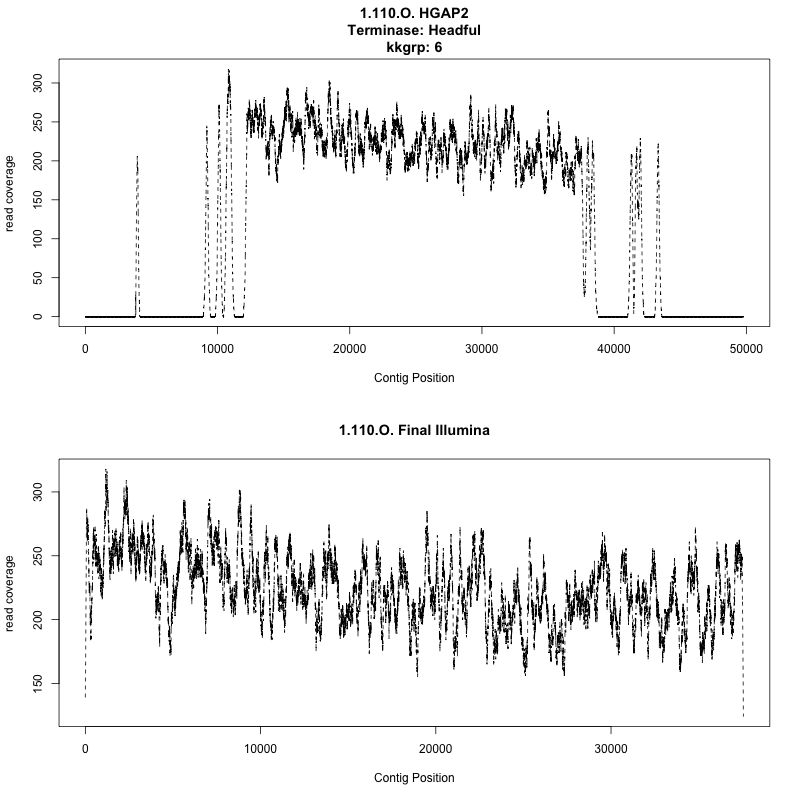

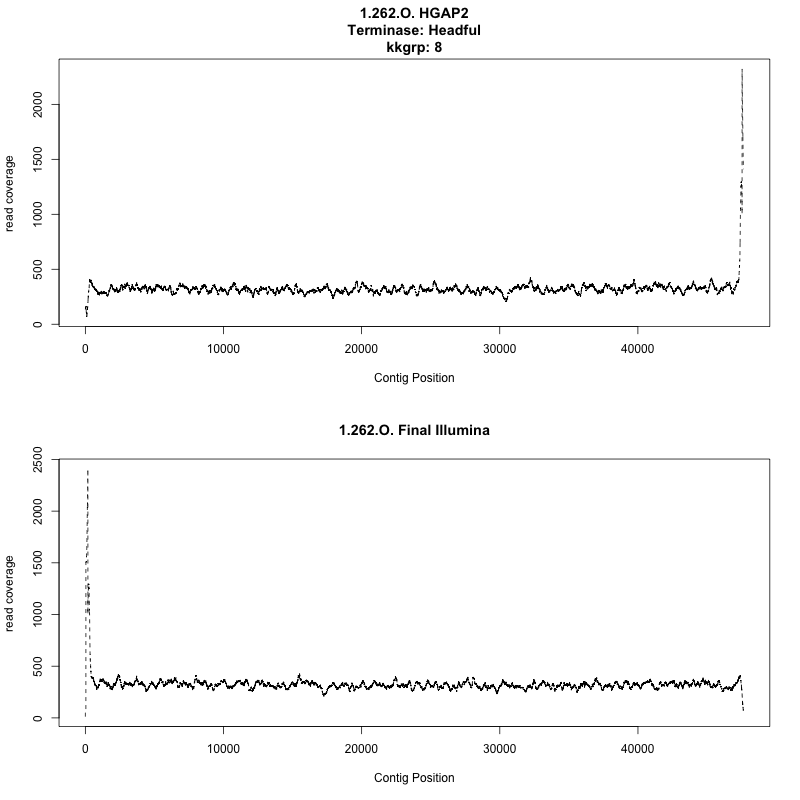

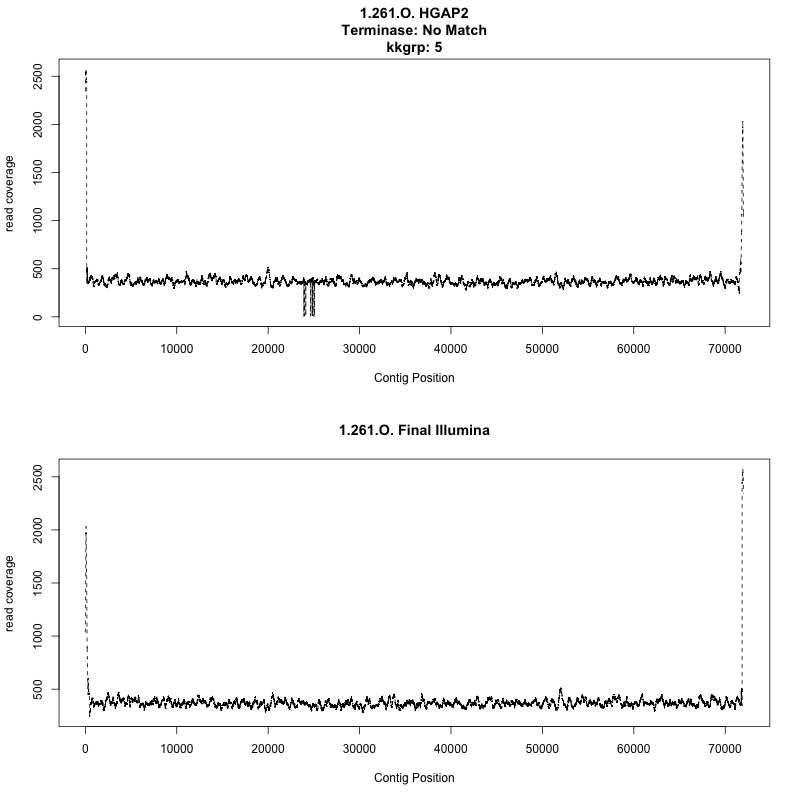

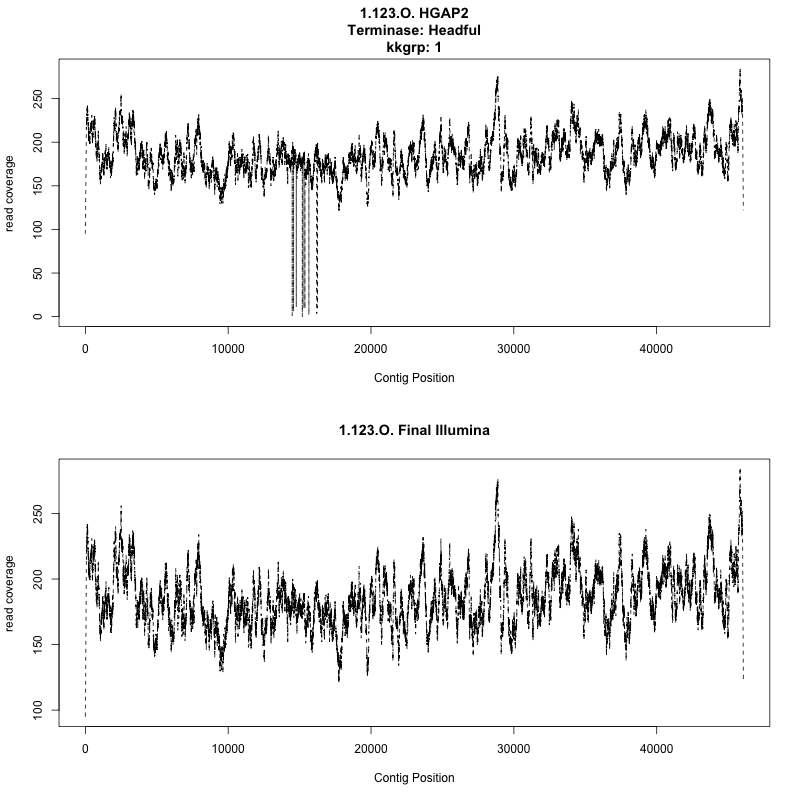

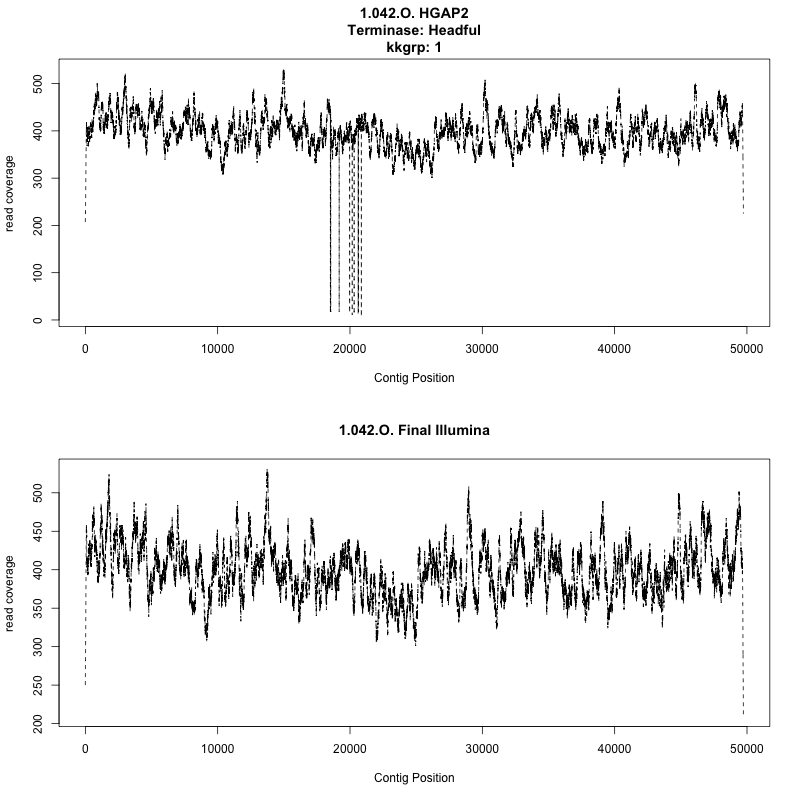

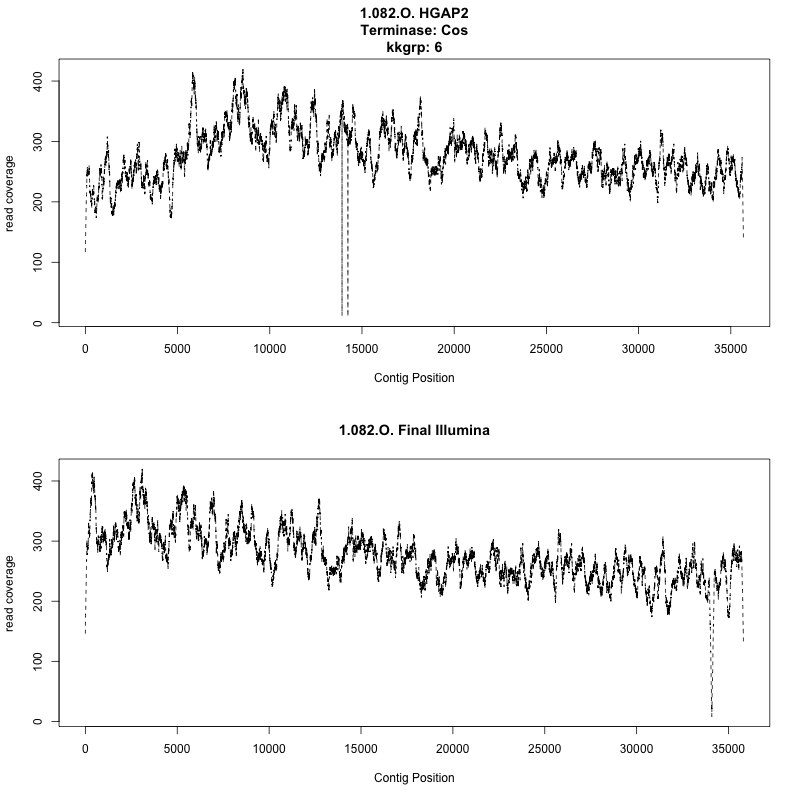

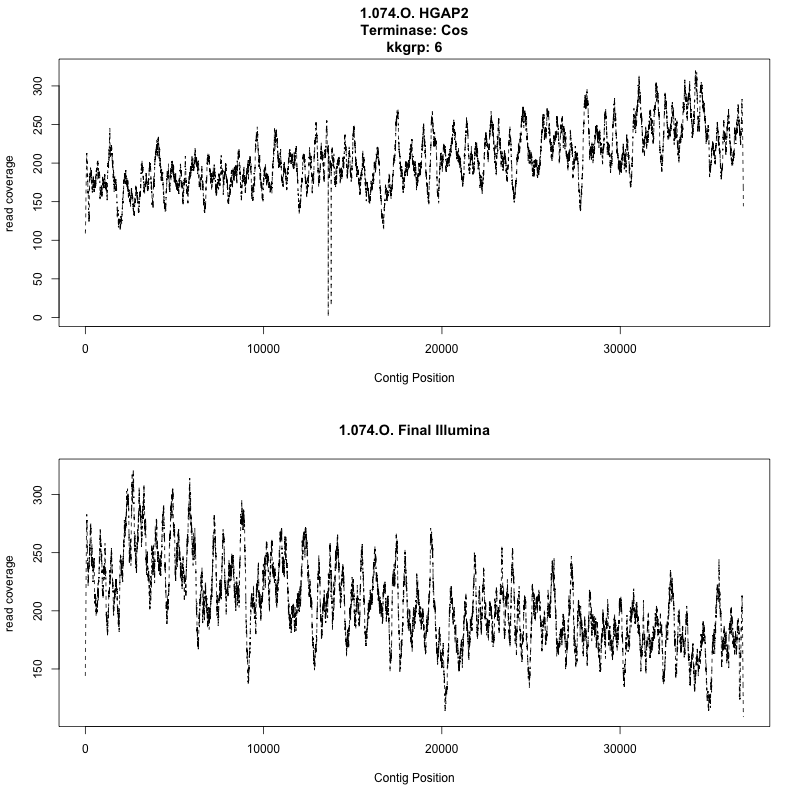

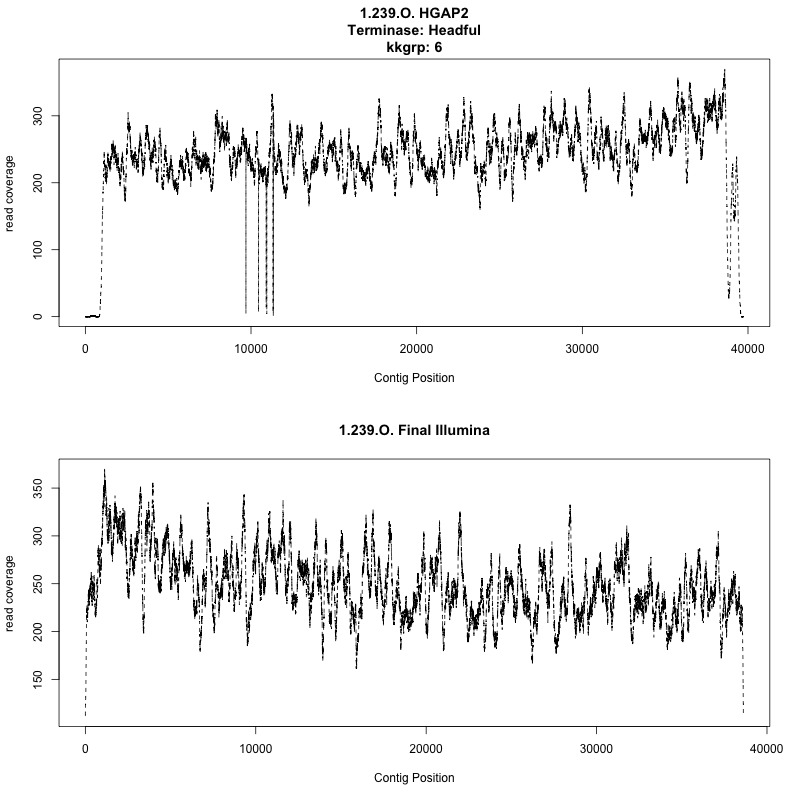

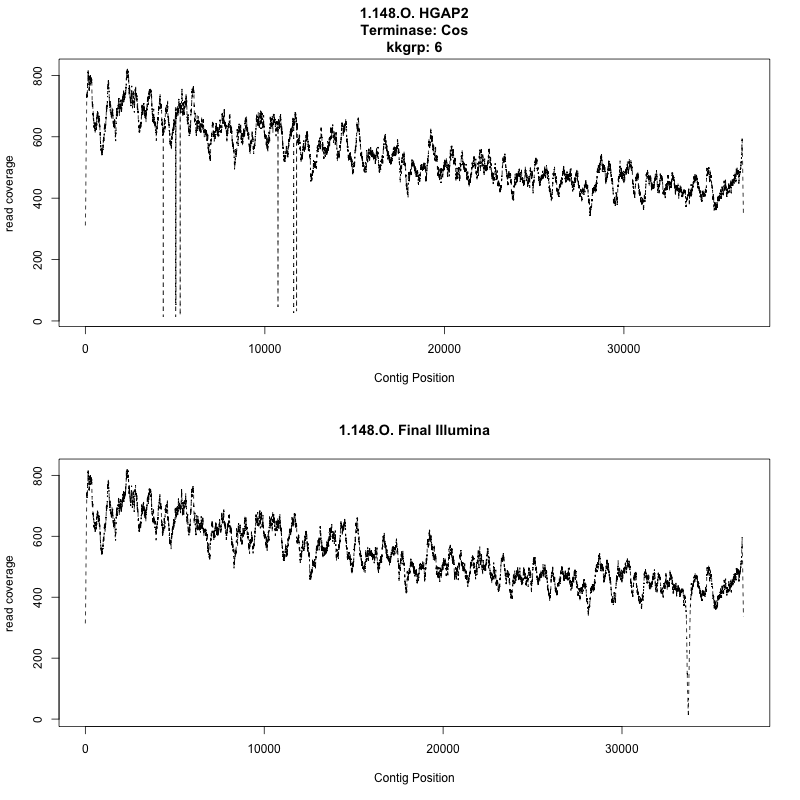

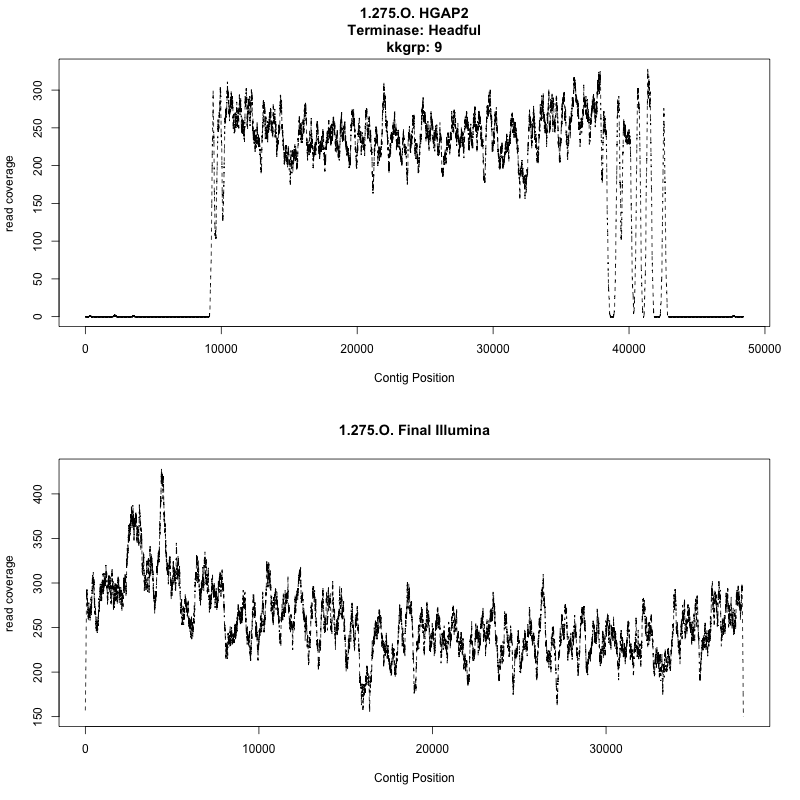

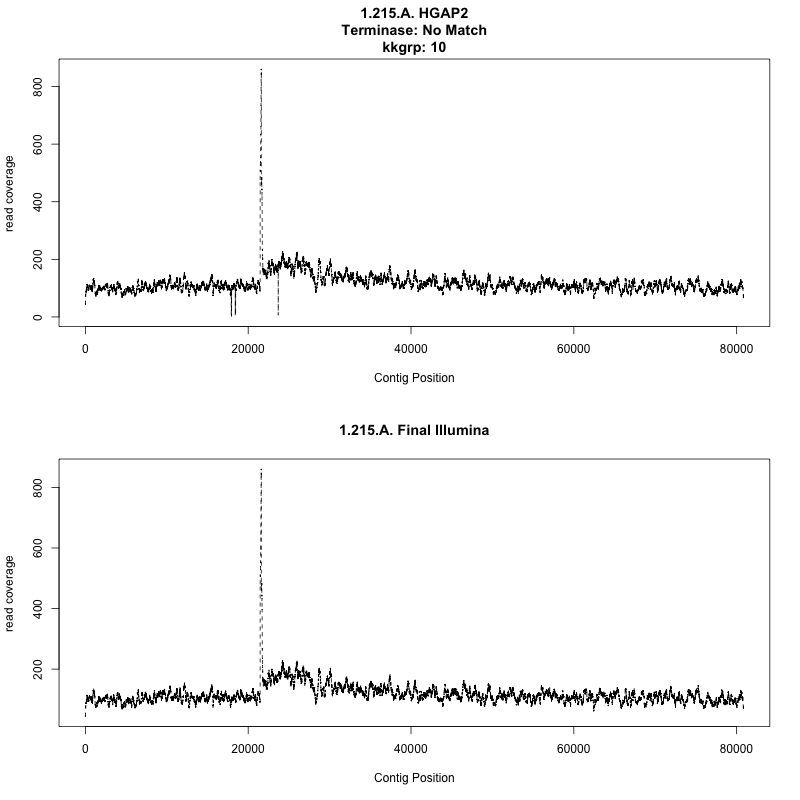

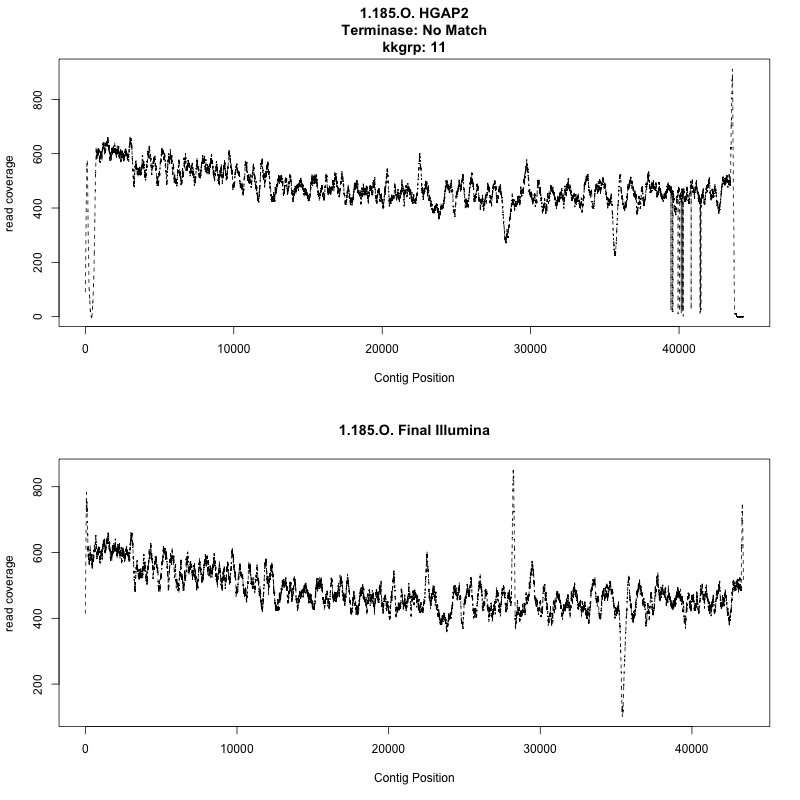

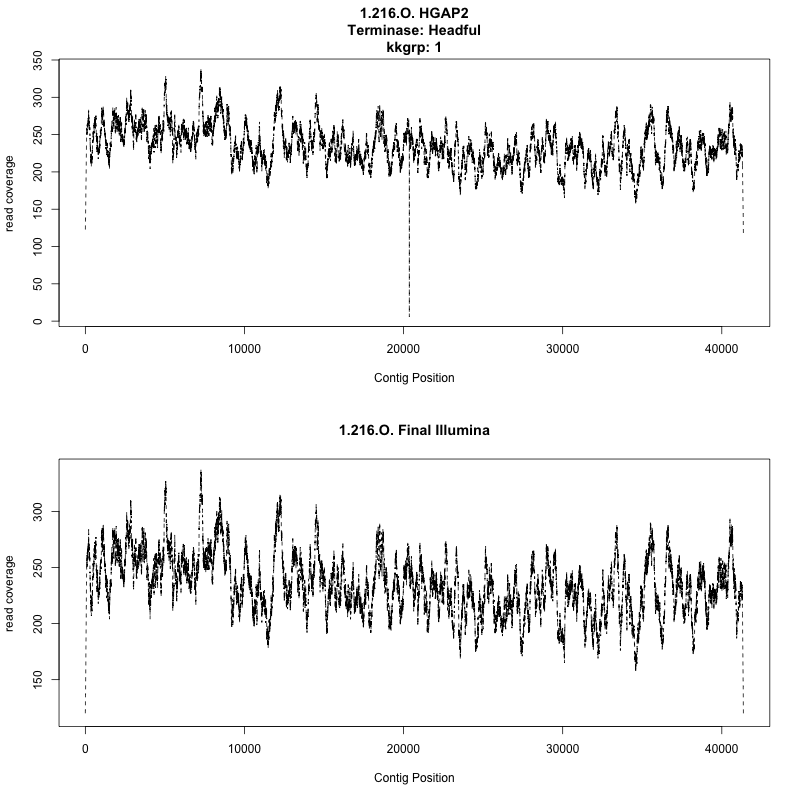

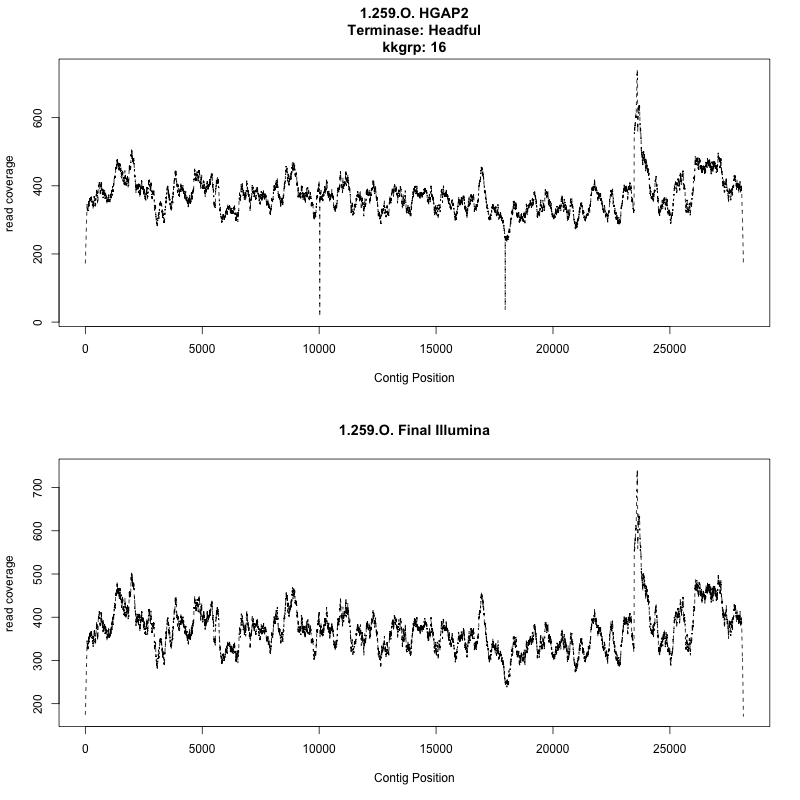

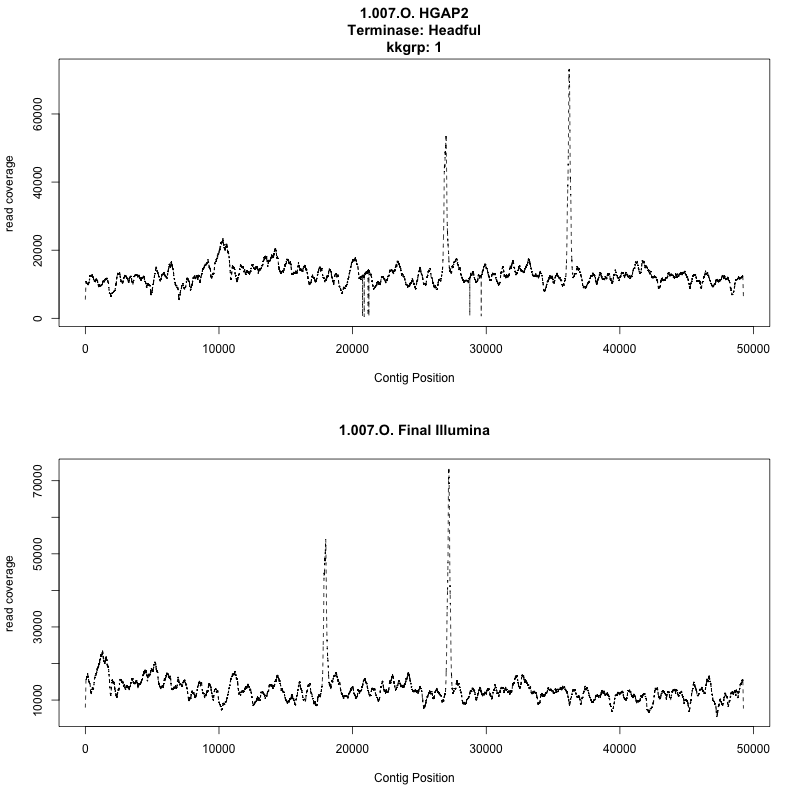

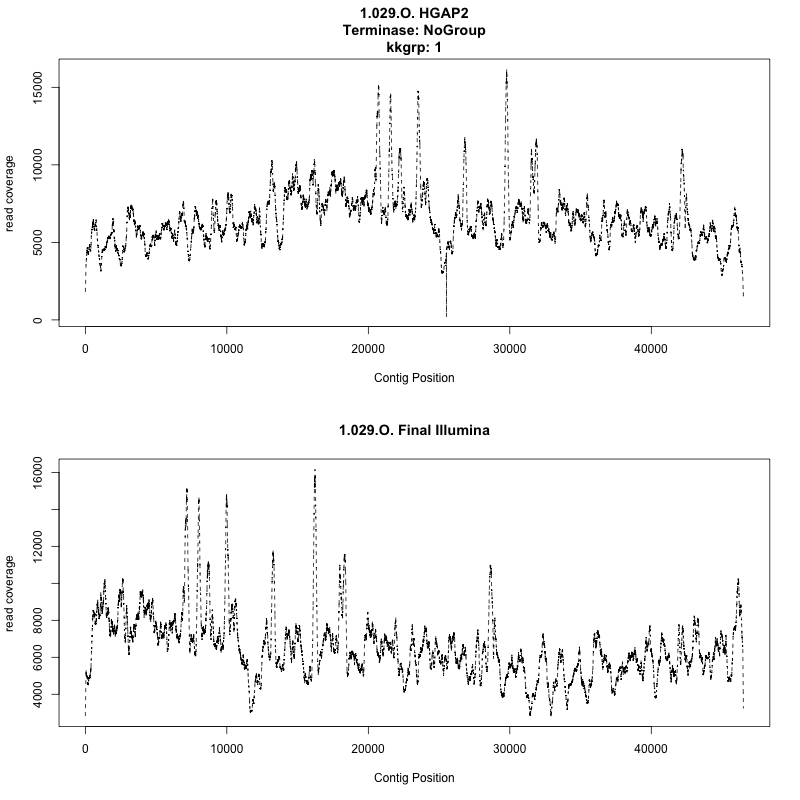

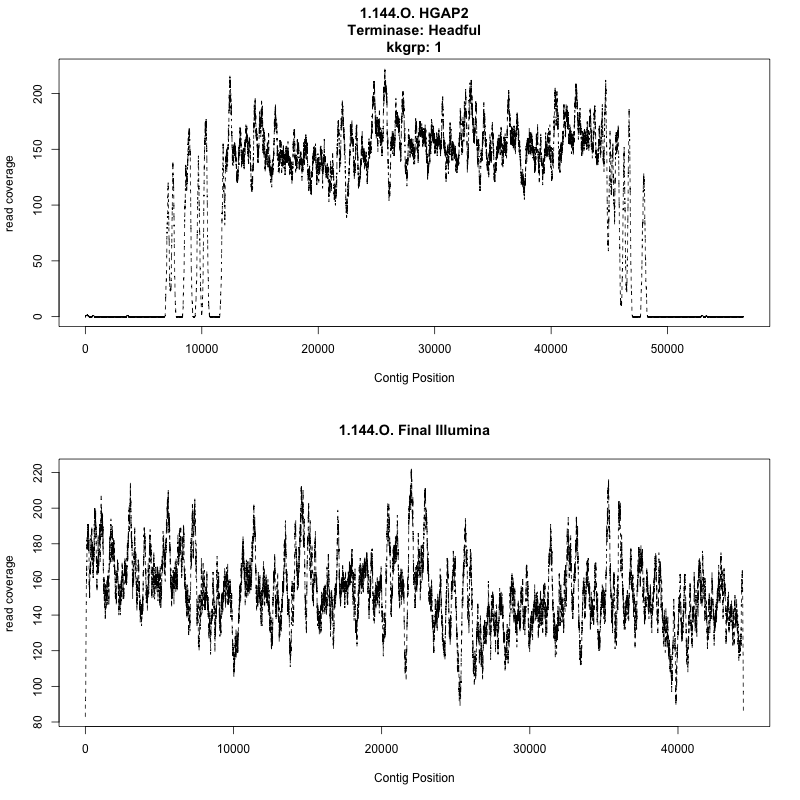

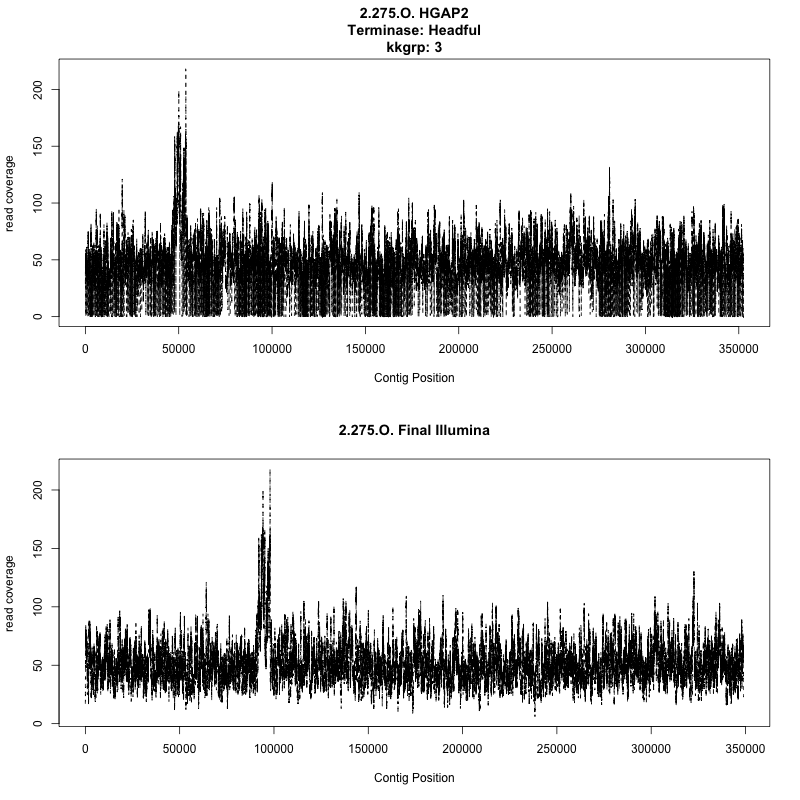

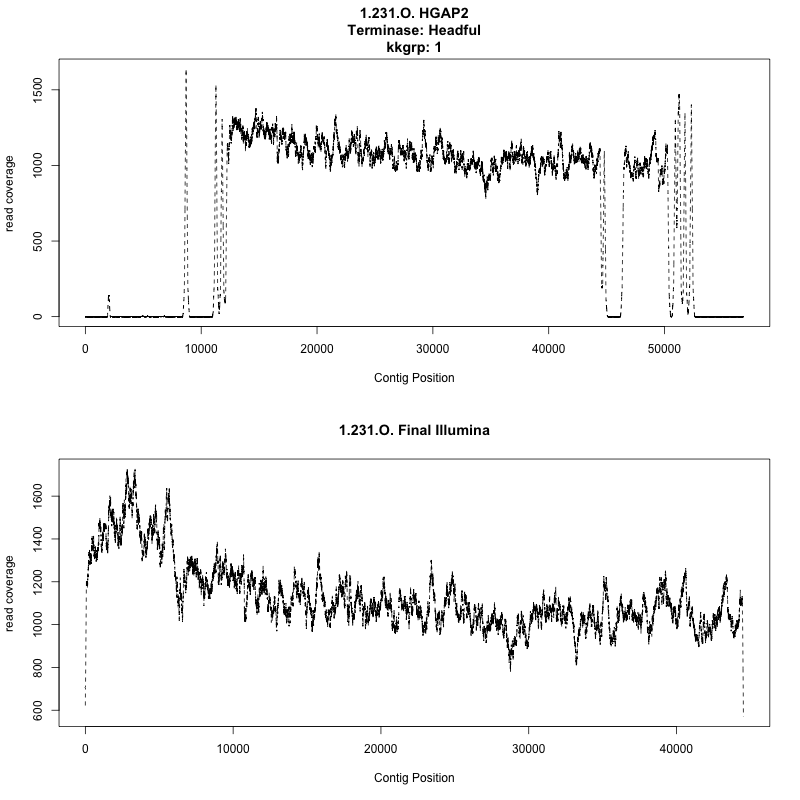

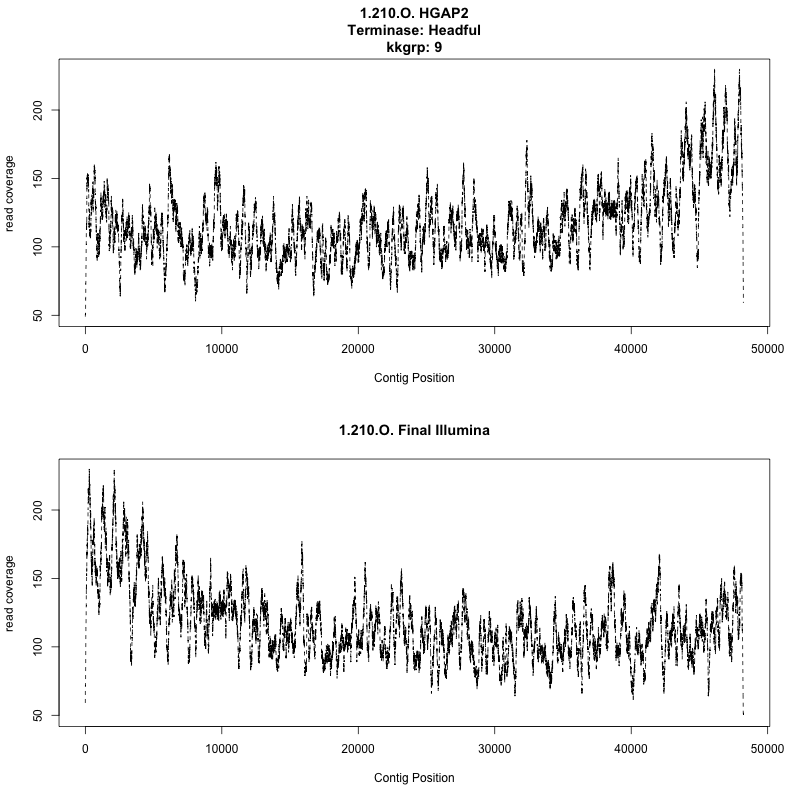

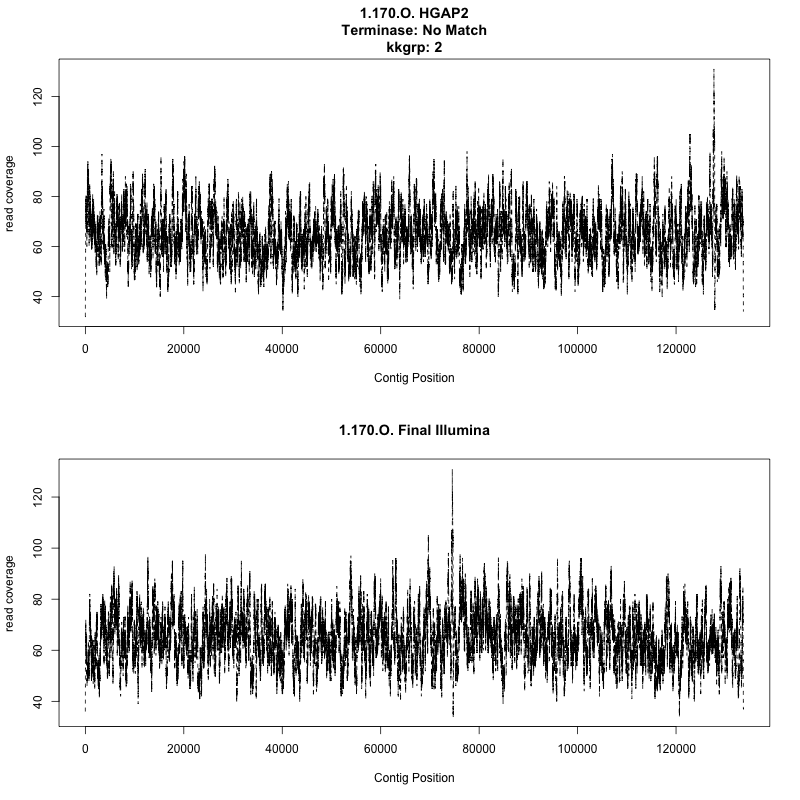

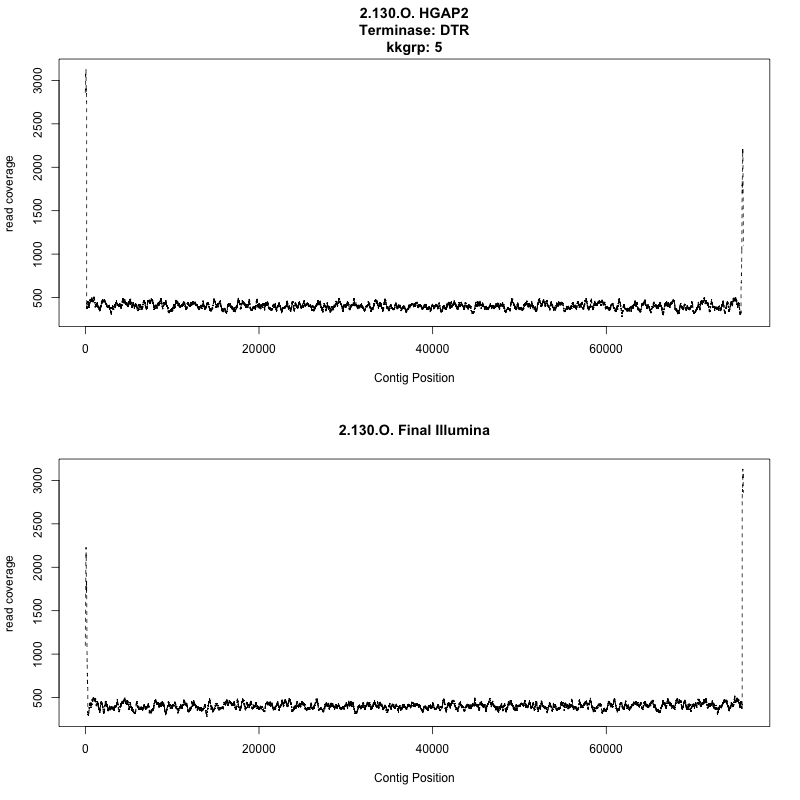

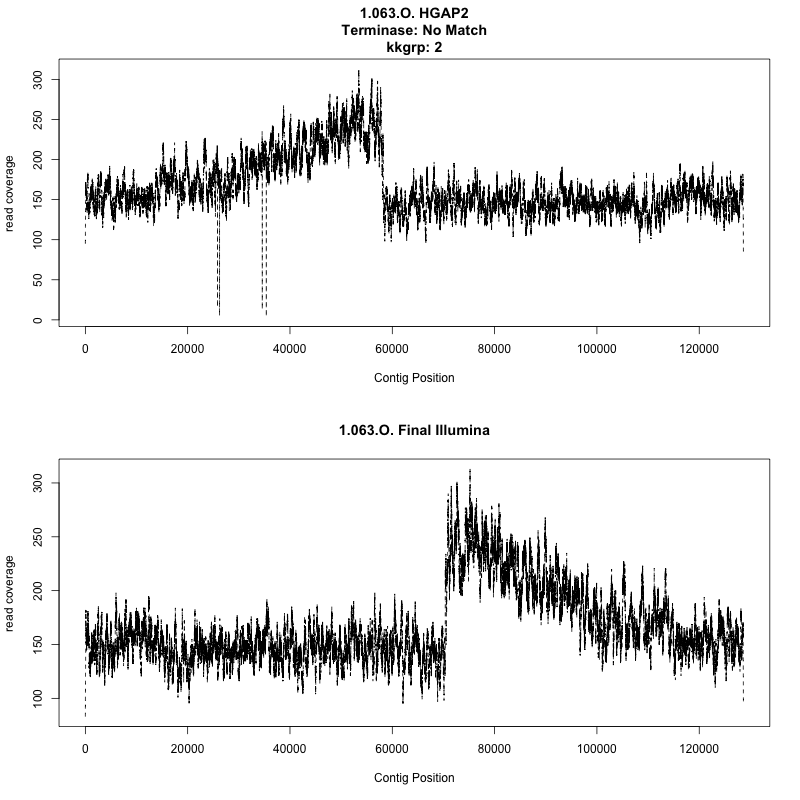

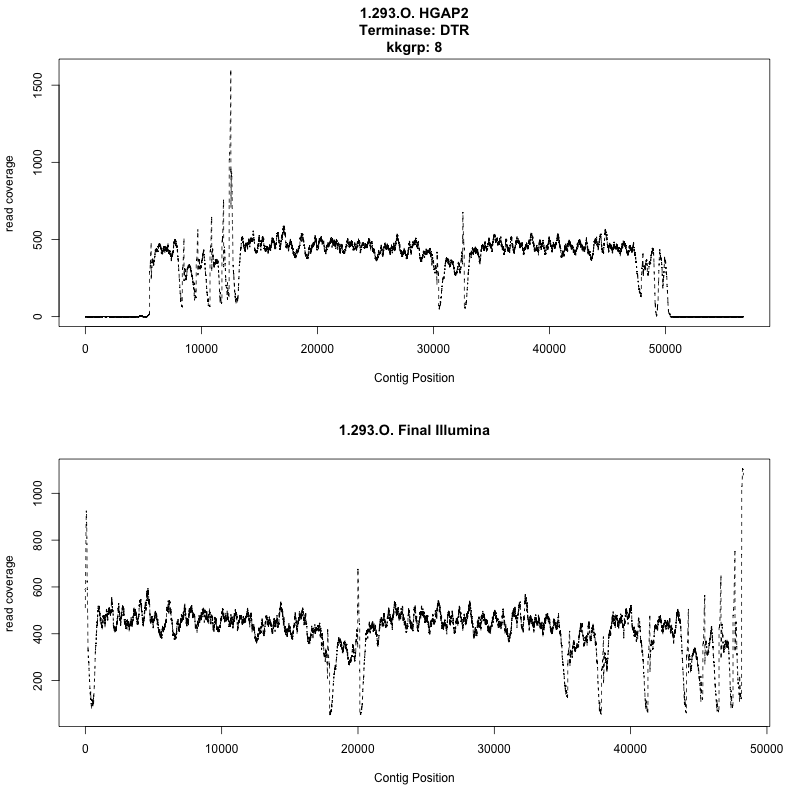

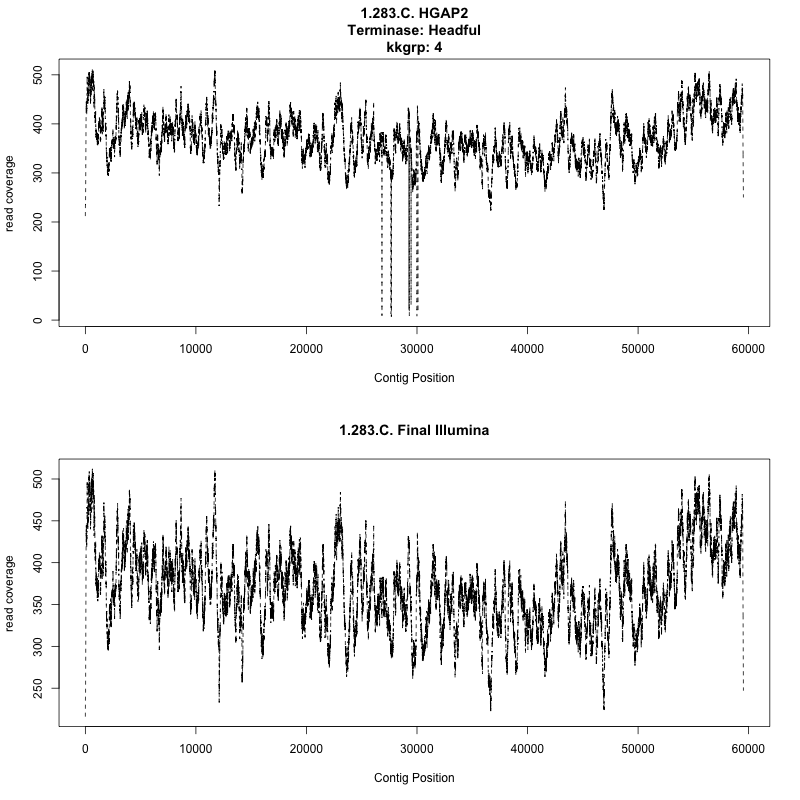

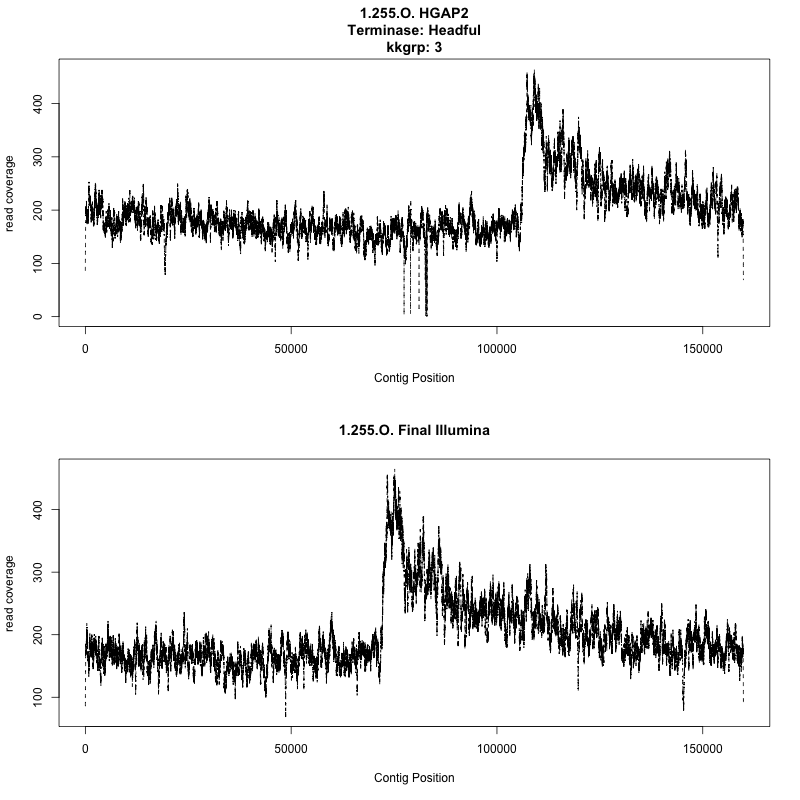

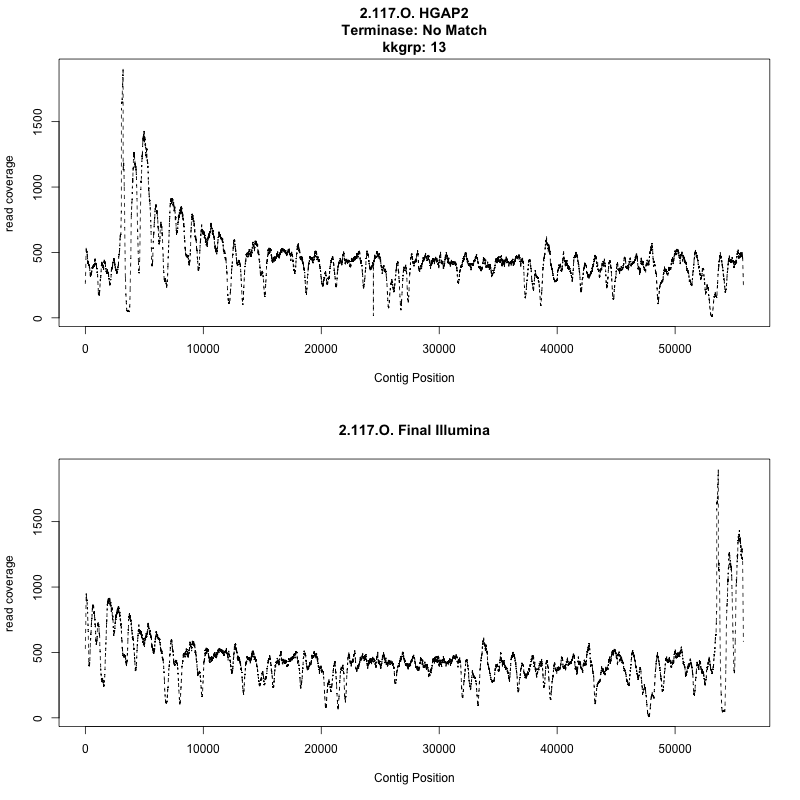

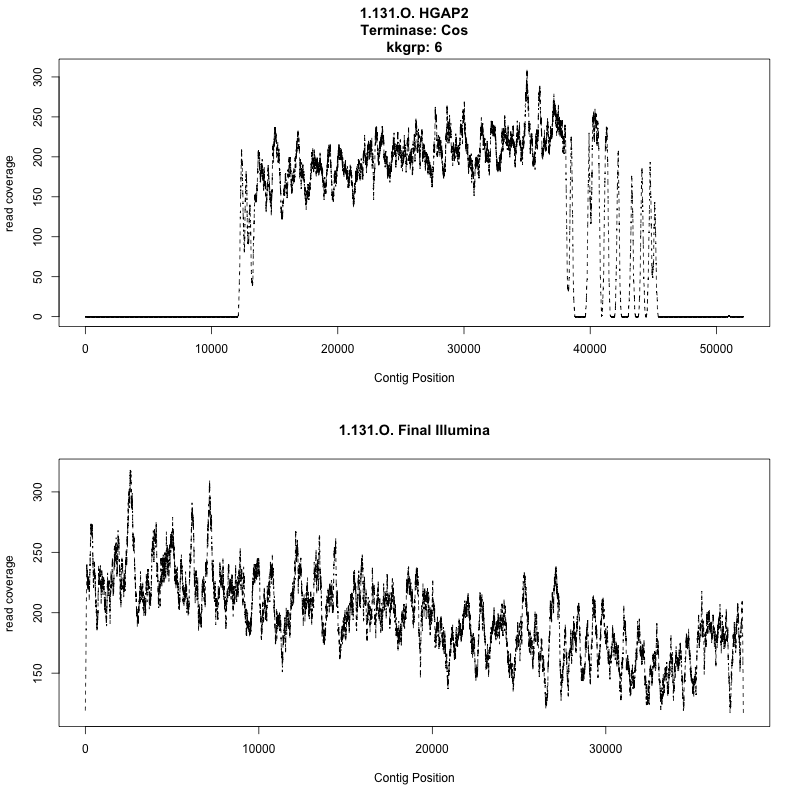

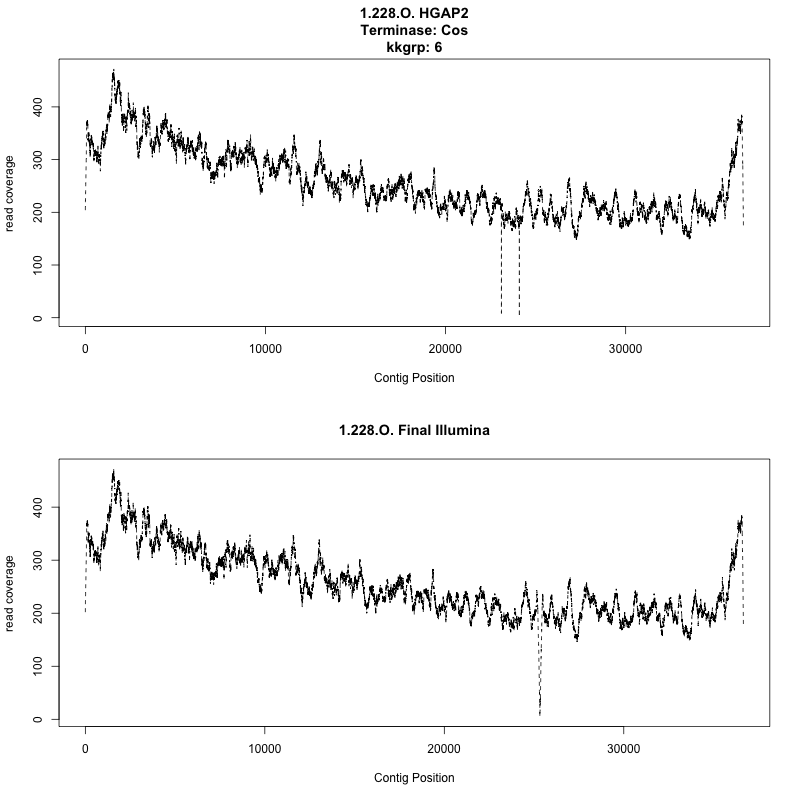

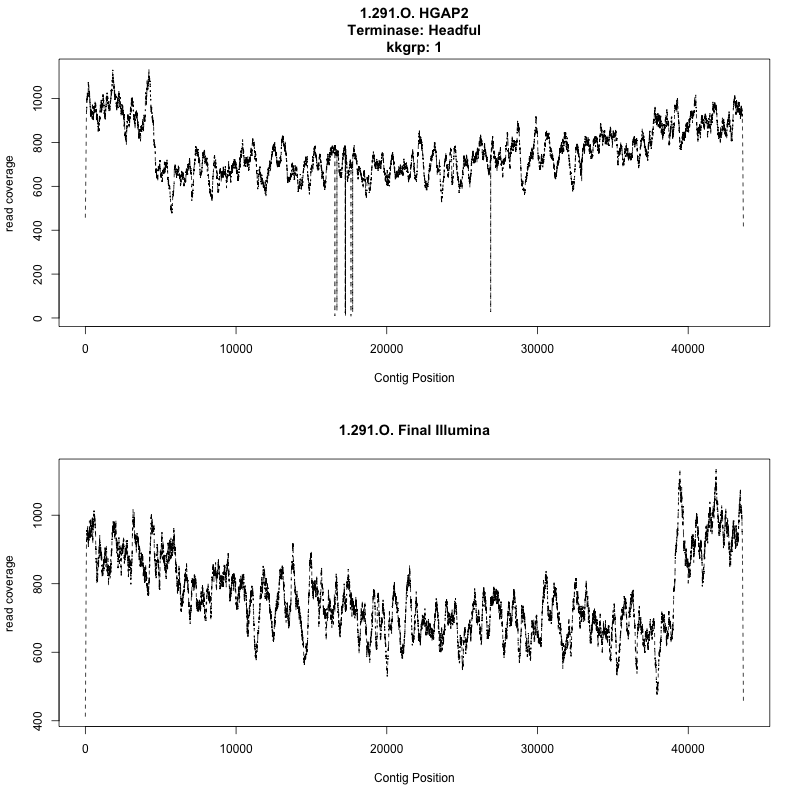

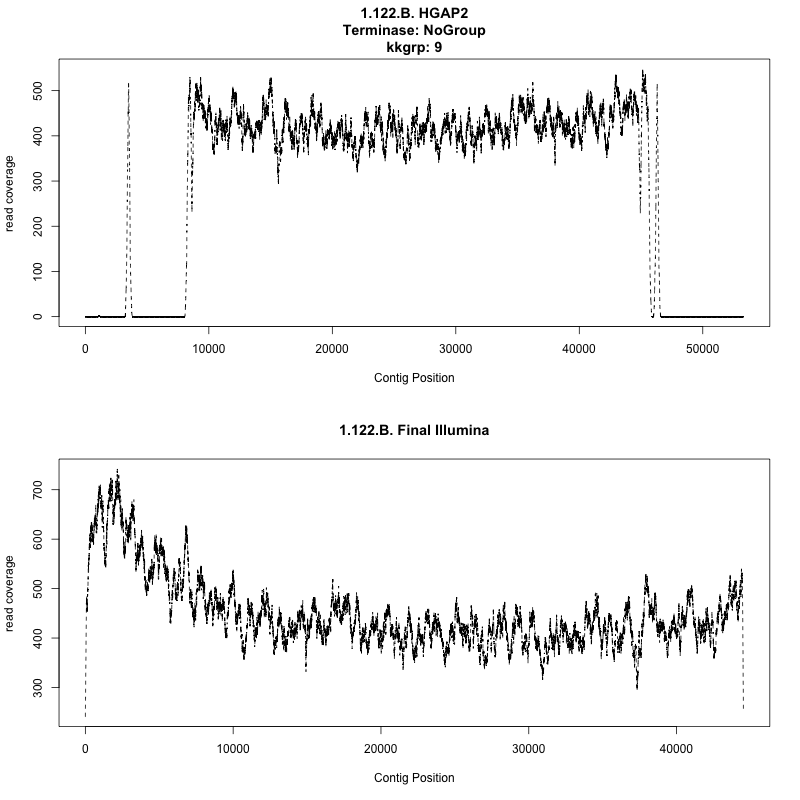

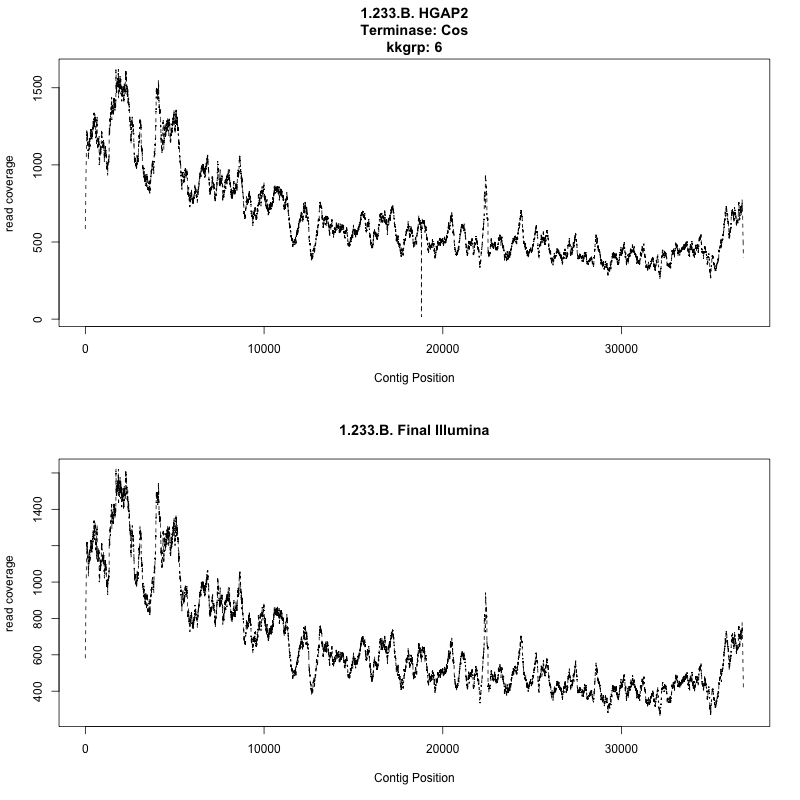

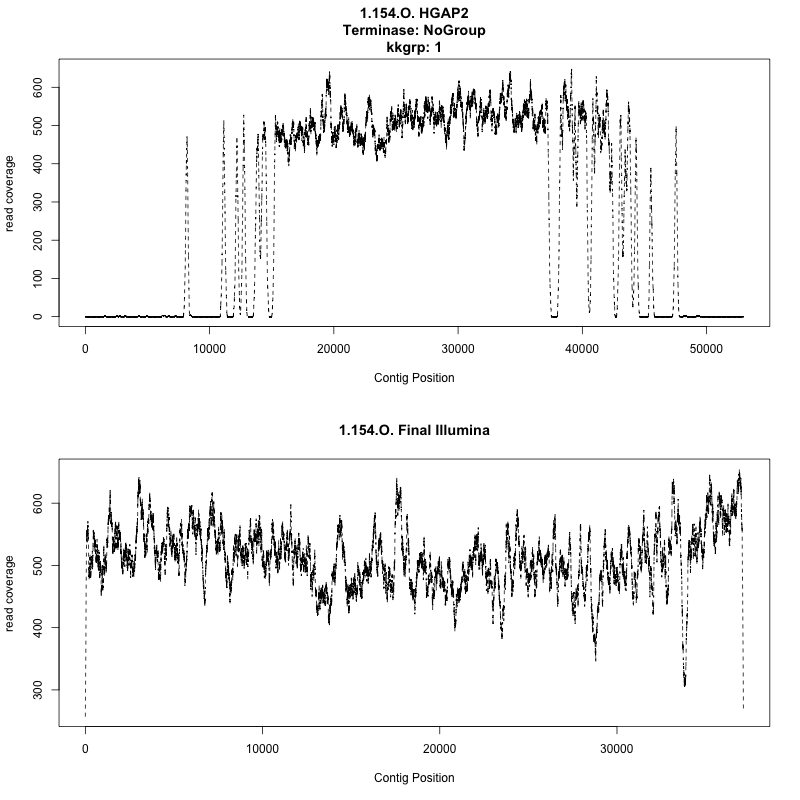

In [53]:
%%R -i phagelist -h 800 -w 800

for (item in phagelist){
    folder = "./data/kkhgap2_illuminacov/"
    
    terminase <- all_info$term_blast_sd[which(all_info$phage==item)]
    if (is.na(terminase)){terminase<-"No Match"}
    
    kkgrp <- all_info$kk_grp[which(all_info$phage==item)]
    
    hgap<-paste(folder, item,"_kkhgap_illumina_readrecruitment.txt",sep="")
    illumina<-paste(folder, item, "_illumina_final_contig_readrecruitment.txt", sep="")
    coverage<-read.table(hgap, sep="\t")
    coverage2<-read.table(illumina, sep="\t")
    layout(matrix(c(1,2),2,1,byrow=TRUE))
    with(coverage, plot(V2, V3, type="l", lty=2, cex=2, main=paste(item,"HGAP2\n","Terminase:",terminase,"\nkkgrp:",kkgrp, sep=" "), xlab="Contig Position", ylab="read coverage"))
    with(coverage2, plot(V2, V3, type="l", lty=2, cex=2, main=paste(item,"Final Illumina", sep=" "), xlab="Contig Position", ylab="read coverage"))
}